# Assignment 3
## Ahmadsho Akdodshoev

https://colab.research.google.com/drive/1e32W622ucyuL76ZLVX6veggS9QnPOJpF?usp=sharing

# **Stabilization of Cart Pole system**: 
> Consider cart pole system:
>
>
><p><img alt="mbk" height="250px" src="https://drive.google.com/uc?id=1O1iM6MByfMyrO0txAMFb_miOqPNzFAvm" align="center" hspace="350px" vspace="0px"></p>
>
>
> Do the following:
>   1. Design the linear feedback controller using linearization of the cart-pole dynamics.
>   1. Simulate the response of your controller on the linearized and nonlinear system, compare the results.
>   1. Taking into account that $y = Cx$ is measured, design observer and linear control that uses observer state. 
>   1. Simulate the nonlinear system with the observer and controller, show the difference between the actual motion of the nonlinear system and its estimate produced by the observer.
>
> [Here is the great illustration of the hardware implemintation of the cart-pole](https://www.youtube.com/shorts/NJxBJ2LJY7w) 


## **System Dynamics**: 

Recall the dynamics of cart-pole system:
\begin{equation}
\begin{cases} 
\left(M+m\right){\ddot {p}}-m L \ddot{\theta} \cos \theta +m L \dot{\theta }^{2}\sin \theta = u \\
L \ddot{\theta}- g\sin \theta =\ddot{p} \cos \theta  \\
\end{cases}
\end{equation}

where $\theta$ is angle of the pendulum measured from the upper equilibrium and $p$ is position of cart


Choosing the state to be $\mathbf{x} = [\theta, \dot{\theta}, p, \dot{p}]^T$ One may rewrite this dynamics in the state-space form as:
\begin{equation}
\mathbf{\dot{x}} = 
\begin{bmatrix}
\dot{\theta} \\ 
\ddot{\theta} \\ 
\dot{p} \\ 
\ddot{p}
\end{bmatrix} 
= 
\begin{bmatrix}
\dot{\theta} \\ 
\frac{(M+m)g \sin \theta - mL \dot{\theta}^2 \sin\theta \cos\theta}{(M + m\sin^2 \theta)L} \\ 
\dot{x} \\ 
\frac{mg\sin\theta \cos\theta - mL\dot{\theta}^2 \sin \theta}{M + m\sin^2 \theta} \\ 
\end{bmatrix} 
+
\begin{bmatrix}
0 \\ 
\frac{\cos\theta}{(M + m\sin^2 \theta)L} \\ 
0 \\ 
\frac{1}{M + m\sin^2 \theta} \\ 
\end{bmatrix} u
\end{equation}


### **System parameters**: 
Let us choose the following parameters:

In [1]:
m = 0.5 # mass of pendulum bob
M = 2 # mass of cart
pendulumn_length = 0.3 # length of pendulum
g = 9.81 # gravitational acceleration


#### **Nonlinear dynamics**: 

First of all let us define the nonlinear system in form $\dot{\mathbf{x}} = \mathbf{f}(\mathbf{x}, \mathbf{u})$ :

In [2]:
import numpy as np
from math import cos, sin

import matplotlib.pyplot as plt

# sin, cos = np.sin, np.cos
# Nnonlinear cart-pole dynamics
def f(x, u):
    theta, dtheta, p, dp = x
    u = u[0]

    denominator = M + m*(sin(theta)**2)
    ddtheta = ((M + m)*g*sin(theta) - m* pendulumn_length * dtheta**2 *sin(theta) * cos(theta) + cos(theta)*u)/(denominator * pendulumn_length)
    ddp = (m*g*sin(theta)*cos(theta) - m* pendulumn_length * dtheta**2 *sin(theta) + u)/denominator

    dx = np.array([dtheta, ddtheta, dp, ddp])
    return dx

x0 = np.array([1, # Initial pendulum angle
      0, # Initial pendulum angular speed
      1, # Initial cart position
      0]) # Initial cart speed
u0 = np.array([0])
print(f(x0, u0))

[ 0.         29.22225161  0.          0.947331  ]


### **Linearized Dynamics**: 

Linearization around the upper equilibrium $\mathbf{x} = [0,0,0,0]$ yields:

\begin{equation}
\mathbf{\dot{x}} = 
\begin{bmatrix}
\dot{\theta} \\ 
\ddot{\theta} \\ 
\dot{p} \\ 
\ddot{p}
\end{bmatrix} 
=
\begin{bmatrix}
0 & 1 & 0 & 0\\
\frac{(M+m)}{M}\frac{g}{L} & 0 & 0 & 0 \\
0 & 0 & 0 & 1 \\
\frac{m}{M}g & 0 & 0 & 0 
\end{bmatrix} 
\begin{bmatrix}
\theta \\ 
\dot{\theta} \\ 
p \\ 
\dot{p}
\end{bmatrix} 
+
\begin{bmatrix}
0 \\
\frac{1}{ML} \\
0 \\
\frac{1}{M}
\end{bmatrix}
u
\end{equation}

In [3]:
# System matrix
A = np.array([[0, 1, 0, 0],
             [(M + m)*g /(M*pendulumn_length), 0, 0, 0],
             [0,0,0,1],
             [m*g/M, 0, 0, 0]])
# Input matrix
B = np.array([[0],
             [1/(M*pendulumn_length)],
             [0], 
             [1/M]])
C = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]])

### **Controller Design**: 

Let us design the controller for linearized plant by placing poles (eigenvalues) on the left-hand side of complex plane:


1. When full state information is available:

In [4]:
import scipy.linalg
from scipy.linalg import solve_continuous_are as are


def lqr(A, B, Q, R):
    # Solve the ARE
    S = are(A, B, Q, R)
    R_inv = np.linalg.inv(R)
    K = R_inv.dot((B.T).dot(S))
    Ac = A - B.dot(K)
    E = np.linalg.eigvals(Ac)
    return S, K, E

Q = np.eye(4)
R = np.eye(1)

S, K, Lambda = lqr(A,B,Q,R)

print(f"K:\n{K}\n")

ABK = A-B@K
print(f"A - BK = {ABK}")
print(f"Eigenvalues of A - BK:\n{scipy.linalg.eigvals(ABK)}\n")

K:
[[57.21562595  9.16054991 -1.         -2.76852949]]

A - BK = [[  0.           1.           0.           0.        ]
 [-54.48437659 -15.26758319   1.66666667   4.61421582]
 [  0.           0.           0.           1.        ]
 [-26.15531298  -4.58027496   0.5          1.38426475]]
Eigenvalues of A - BK:
[-7.27796728+0.j         -5.62563763+0.j         -0.48985677+0.39921673j
 -0.48985677-0.39921673j]



2. When only measurement $y = C\cdot x$ is available:

In [5]:
Q_o = np.diag([1,1,1,1])
R_o = np.diag([1,1,1])
S, LT, Lambda = lqr(A.T, C.T, Q_o, R_o)
L = LT.T

print(f"L:\n{L}\n")

ALC = A-L@C
print(f"A - LC = {ALC}")
print(f"Eigenvalues of A - LC:\n{scipy.linalg.eigvals(ALC)}\n")

L:
[[4.72075388e-01 2.33303588e+00 1.26555552e-02]
 [2.33303588e+00 1.36482789e+01 8.43208174e-02]
 [1.26555552e-02 8.43208174e-02 1.73388362e+00]
 [1.40320311e-01 8.09266563e-01 1.00681129e+00]]

A - LC = [[-4.72075388e-01 -1.33303588e+00 -1.26555552e-02  0.00000000e+00]
 [ 3.85419641e+01 -1.36482789e+01 -8.43208174e-02  0.00000000e+00]
 [-1.26555552e-02 -8.43208174e-02 -1.73388362e+00  1.00000000e+00]
 [ 2.31217969e+00 -8.09266563e-01 -1.00681129e+00  0.00000000e+00]]
Eigenvalues of A - LC:
[-7.06031564+2.82381539j -7.06031564-2.82381539j -0.86680331+0.50047138j
 -0.86680331-0.50047138j]



\begin{equation}
\begin{cases}
\dot {\mathbf{x}} = \mathbf{A} \mathbf{x} + \mathbf{B} \mathbf{u} \\
\dot{\hat {\mathbf{x}}} = \mathbf{A} \hat{\mathbf{x}} + \mathbf{B} \mathbf u + \mathbf{L}(\mathbf y - \mathbf{C} \hat{\mathbf{x}})\\
\mathbf{y} = \mathbf{C} \mathbf{x} \\
\mathbf{u} = -\mathbf{K} \hat{\mathbf{x}}
\end{cases}
\end{equation}

Collecting $\dot{x}$ and $\dot{e}$ we get:

\begin{equation}
\begin{cases}
\dot {\mathbf{x}} = (\mathbf{A}-\mathbf{B}\mathbf{K}) \mathbf{x} +  \mathbf{B}\mathbf{K}\mathbf{e} \\
\dot{\mathbf{e}} = 
(\mathbf{A}  - \mathbf{L}\mathbf{C})\mathbf{e}
\end{cases}
\end{equation}

In matrix form it becomes:
\begin{equation}
\begin{bmatrix}
\dot {\mathbf{x}} \\
\dot{\mathbf{e}}
\end{bmatrix}
=
\begin{bmatrix}
(\mathbf{A}-\mathbf{B}\mathbf{K}) & \mathbf{B}\mathbf{K} \\
0 & (\mathbf{A}  - \mathbf{L}\mathbf{C})
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{e}
\end{bmatrix}
\end{equation}

Eigenvalues of a upper block-triangular matrices equal to the union of the eigenvalues of the blocks on the main diagonal. Hence here, the eigenvalues of the system are equal to the union of eigenvalues of $(\mathbf{A}-\mathbf{B}\mathbf{K})$ and $(\mathbf{A}  - \mathbf{L}\mathbf{C})$. 

## **Simulation**:
We proceed with the simulation of designed controller, firstly we will define the simulation parameters: 

In [6]:
# Time settings
t0 = 0 # Initial time 
tf = 10 # Final time
N = 1000 # Numbers of points in time span
t = np.linspace(t0, tf, N) # Create time span

# Define initial point 
theta_0 = 0.4
p_0 = 0.1

# Set initial state 
x0 = np.array([theta_0, # Initial pendulum angle
      0, # Initial pendulum angular speed
      p_0, # Initial cart position
      0]) # Initial cart speed


#### **Linearized dynamics**: 
Now let us simulate the response of linear controller on the **linearized** system:

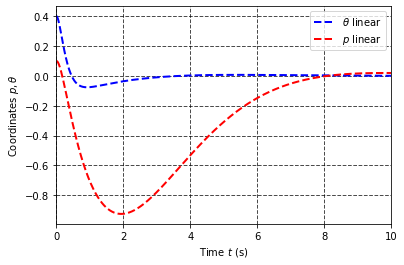

In [7]:
# import integrator routine
from scipy.integrate import odeint 

# Define the linear ODE to solve
def linear_ode(x, t, A, B, K):
    # Linear controller
    u = - np.dot(K,x) 
    # Linearized dynamics
    dx = np.dot(A,x) + np.dot(B,u)
    return dx

# integrate system "sys_ode" from initial state $x0$
x_l = odeint(linear_ode, x0, t, args=(A, B, K)) 
theta_l, dtheta_l, p_l, dp_l = x_l[:,0], x_l[:,1], x_l[:,2], x_l[:,3] 
# Plot the resulst
plt.plot(t, theta_l, 'b--', linewidth=2.0, label = r'$\theta$ linear')
plt.plot(t, p_l, 'r--', linewidth=2.0, label = r'$p$ linear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()

Now we will simulate similarly to linear case while using the same gains $\mathbf{K}$:

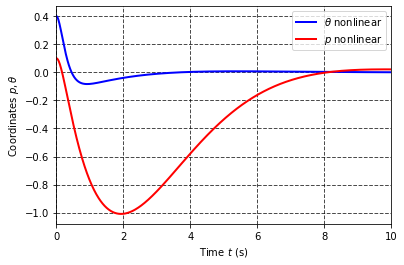

In [8]:
def nonliear_ode(x, t, K):

    # Linear controller
    u = - np.dot(K,x)  

    # Nonlinear dynamics
    dx = f(x, u)
    
    return dx

# integrate system "sys_ode" from initial state $x0$
x_nl = odeint(nonliear_ode, x0, t, args=(K,)) 
theta_nl, dtheta_nl, p_nl, dp_nl = x_nl[:,0], x_nl[:,1], x_nl[:,2], x_nl[:,3] 
# Plot the resulst
plt.plot(t, theta_nl, 'b', linewidth=2.0, label = r'$\theta$ nonlinear')
plt.plot(t, p_nl, 'r', linewidth=2.0, label = r'$p$ nonlinear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.show()

### Simulation with observer

Insert your code simulating the behavior of the nonlinear system with an observer. Plot the results, compare state estimation and actual state of the system.

Let us introduce a Luenberger observer:
$$\dot{\hat{x}} = A\hat{x} + Bu + L(y - C\hat{x})$$

Introducing an estimator 
$$e = \hat{x} - x$$
will lead to having 
$$\dot{e} = (A-LC)e.$$

Thus, if all eigenvalues of $A-LC$ have negative real parts, the estimation error will converge to zero.

In [9]:
def observer_controller(state, t, system_param, observer_params):

    x, x_hat = np.split(state,2)
  
    A = system_param['A']
    B = system_param['B']
    K = system_param['K']

    C = observer_params['C']
    L = observer_params['L']
    A_obs = observer_params['A']

    # 
    K = np.array(K)
    u = -K@x#_hat

    # dx = A@x + B@u
    dx = f(x, u)

    y = np.dot(C, x)
    
    # 
    y_hat = np.dot(C, x_hat)
    e = y -  y_hat
    
    dx_hat = np.dot(A_obs,x_hat) + np.dot(B, u) + np.dot(L, e)
    
    #
    dstate = np.hstack((dx, dx_hat))
    
    # dstate = dx, dx_hat
    return dstate

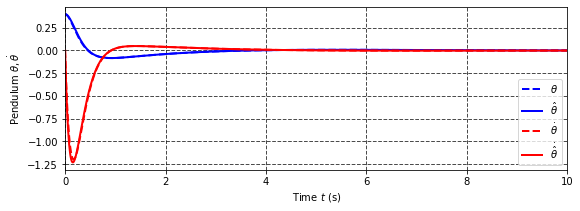

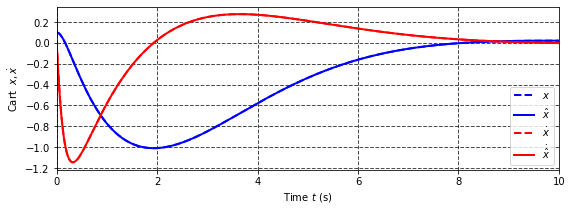

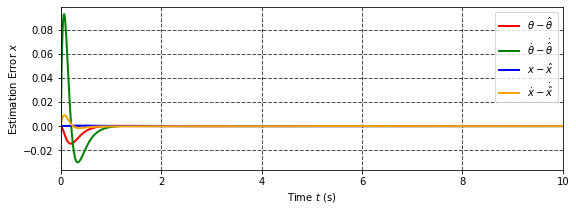

In [18]:
from matplotlib.pyplot import *

A_o = A
Q_c = np.diag([1,1,1,1])
R_c = np.diag([1])

_, K, _ = lqr(A, B, Q_c, R_c)
system_params = {'A':A,'B':B,'K':K}

Q_o = np.diag([1,1,1,1])
R_o = np.diag([1,1,1])
_, LT, _ = lqr(A_o.T, C.T, Q_o, R_o)
L = LT.T
observer_params = {'A':A_o,'C':C, 'L':L}

x_real_0 = x0 # Set initial state 
x_hat_0 = x0

state_0 = np.hstack((x_real_0, x_hat_0))

state_sol = odeint(observer_controller, state_0, t, args=(system_params, observer_params, )) # integrate system "sys_ode" from initial state $x0$

x_real, x_hat =np.split(state_sol, 2, axis = 1)

theta, dtheta, x, dx = np.split(x_real, 4, axis = 1)

theta_hat, dtheta_hat, x_hat, dx_hat = np.split(x_hat, 4, axis = 1)

figure(figsize=(9, 3))
plot(t, theta, 'b--', linewidth=2.0, label = r"$\theta$")
plot(t, theta_hat, 'b', linewidth=2.0, label = r"$\hat{\theta}$")
plot(t, dtheta, 'r--', linewidth=2.0, label = r"$\dot{\theta}$")
plot(t, dtheta_hat, 'r', linewidth=2.0, label = r"$\dot{\hat{\theta}}$")
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Pendulum $\theta,\dot{\theta}$')
xlabel(r'Time $t$ (s)')
legend()
show()

figure(figsize=(9, 3))
plot(t, x, 'b--', linewidth=2.0, label = r"$x$")
plot(t, x_hat, 'b', linewidth=2.0, label = r"$\hat{x}$")
plot(t, dx, 'r--', linewidth=2.0, label = r"$\dot{x}$")
plot(t, dx_hat, 'r', linewidth=2.0, label = r"$\dot{\hat{x}}$")
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Cart  $x,\dot{x}$')
xlabel(r'Time $t$ (s)')
legend()
show()

figure(figsize=(9, 3))
plot(t, theta - theta_hat, 'r', linewidth=2.0, label = r"$\theta - \hat{\theta}$")
plot(t, dtheta - dtheta_hat, 'g', linewidth=2.0, label = r"$\dot{\theta} - \dot{\hat{\theta}}$")
plot(t, x - x_hat, 'b', linewidth=2.0, label = r"$x - \hat{x}$")
plot(t, dx - dx_hat, 'orange', linewidth=2.0, label = r"$\dot{x} - \dot{\hat{x}}$")
grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
grid(True)
xlim([t0, tf])
ylabel(r'Estimation Error ${x}$')
xlabel(r'Time $t$ (s)')
legend()
show()


### **Comparison**: 
One may compare the linear and nonlinear responses by plotting them together:

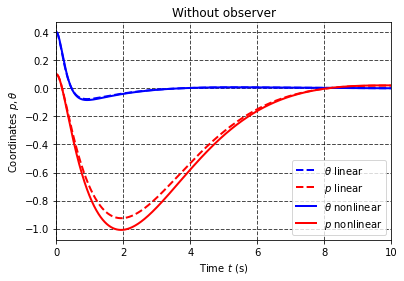

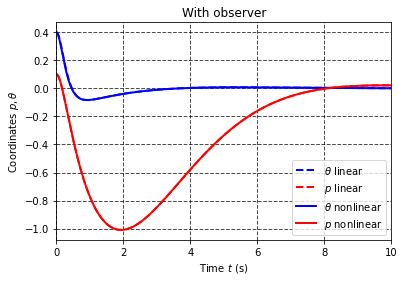

In [11]:
# theta_l, p_l - values of theta and p for the linear system
# theta_nl, p_nl - values of theta and p for the nonlinear system


plt.plot(t, theta_l, 'b--', linewidth=2.0, label = r'$\theta$ linear')
plt.plot(t, p_l, 'r--', linewidth=2.0, label = r'$p$ linear')
plt.plot(t, theta_nl, 'b', linewidth=2.0, label = r'$\theta$ nonlinear')
plt.plot(t, p_nl, 'r', linewidth=2.0, label = r'$p$ nonlinear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.title("Without observer")
plt.show()

theta_l = theta_hat
theta_nl = theta
p_l = x_hat
p_nl = x

plt.plot(t, theta_l, 'b--', linewidth=2.0, label = r'$\theta$ linear')
plt.plot(t, p_l, 'r--', linewidth=2.0, label = r'$p$ linear')
plt.plot(t, theta_nl, 'b', linewidth=2.0, label = r'$\theta$ nonlinear')
plt.plot(t, p_nl, 'r', linewidth=2.0, label = r'$p$ nonlinear')
plt.grid(color='black', linestyle='--', linewidth=1.0, alpha = 0.7)
plt.grid(True)
plt.legend()
plt.xlim([t0, tf])
plt.ylabel(r'Coordinates $p,\theta$')
plt.xlabel(r'Time $t$ (s)')
plt.title("With observer")
plt.show()


# Animation

In [12]:
p = p_nl
theta = theta_nl
time = t

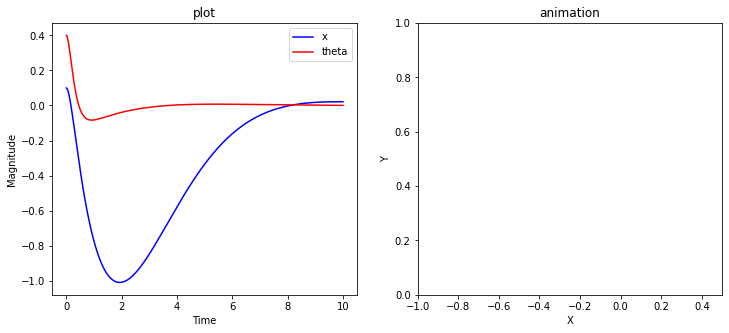

In [13]:
%matplotlib inline

# create a figure and axes
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)

# set up the subplots as needed
# ax1.set_xlim(( 0, 2))            
# ax1.set_ylim((-0.3, 0.3))
ax1.set_xlabel('Time')
ax1.set_ylabel('Magnitude')

ax2.set_xlim((-1,0.5))
ax2.set_ylim((0,1))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('animation')

# create objects that will change in the animation. These are
# initially empty, and will be given new values for each frame
# in the animation.
txt_title = ax1.set_title('plot')
line_x,     = ax1.plot(time, p, 'b')     # ax.plot returns a list of 2D line objects
line_theta, = ax1.plot(time, theta, 'r')
point_x,     = ax1.plot([], [], 'g.', ms=20)
point_theta, = ax1.plot([], [], 'g.', ms=20)

draw_cart,  = ax2.plot([], [], 'b', lw=2)
draw_shaft, = ax2.plot([], [], 'r', lw=2)

ax1.legend(['x','theta']);

In [14]:

shaft_l = 0.3
cart_l = 0.1
cart_x = np.array([-1, -1, 1, 1, -1])*cart_l
cart_y = np.array([ 0,  1, 1, 0,  0])*cart_l


# animation function. This is called sequentially
def drawframe(n):

    shaft_x = np.array([ p[n],  p[n] + shaft_l*sin(theta[n] )])
    shaft_y = np.array([ cart_l/2,  cart_l/2 + shaft_l*cos(theta[n] )])

    line_x.set_data(time, p)
    line_theta.set_data(time, theta)

    point_x.set_data(time[n], p[n])
    point_theta.set_data(time[n], theta[n])

    draw_cart.set_data(cart_x+p[n], cart_y)
    draw_shaft.set_data(shaft_x, shaft_y)
    
    txt_title.set_text('Frame = {0:4d}'.format(n))
    return (draw_cart,draw_shaft)

In [15]:
from matplotlib import animation

# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=1000, interval=20, blit=True)

## Here we try to make a video of the cart-pole as it moves

In [16]:
from IPython.display import HTML
HTML(anim.to_html5_video())